In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install split-folders

> ## Import libraries

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import splitfolders
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


> ## Creating A Directory

In [5]:
main_path_dir=('/kaggle/input/')

data_dir=os.path.join(main_path_dir,'psc-image')

for folder in os.listdir(data_dir):
    folder_path=os.path.join(data_dir,folder)
    print(f"Number of images in {folder}:{len(os.listdir(folder_path))}")
    print()

Number of images in Scentless Mayweed:607

Number of images in Common wheat:253

Number of images in Charlock:452

Number of images in Black-grass:309

Number of images in Sugar beet:463

Number of images in Loose Silky-bent:762

Number of images in Maize:257

Number of images in Cleavers:335

Number of images in Common Chickweed:713

Number of images in Fat Hen:538

Number of images in Small-flowered Cranesbill:576

Number of images in Shepherd’s Purse:274



> ## Plotting Image Data

In [6]:
def plot_images(image_dir,num_images):
    images_list=os.listdir(image_dir)
    images_dir_list=[os.path.join(image_dir,image) for image in images_list][:num_images]
    plt.figure(figsize=(10,10))
    for i,image_dir in enumerate(images_dir_list):
        plt.subplot(5,5,i+1)
        img=plt.imread(image_dir)
        plt.imshow(img)
        

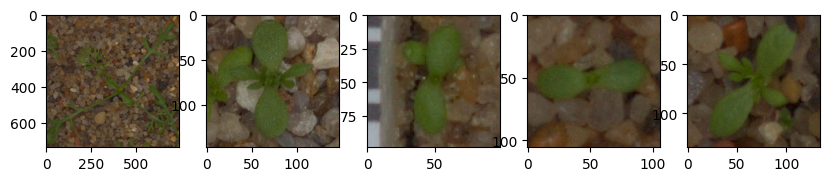

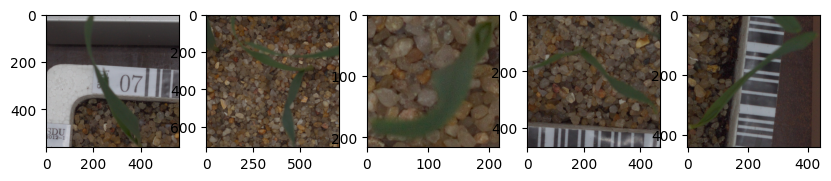

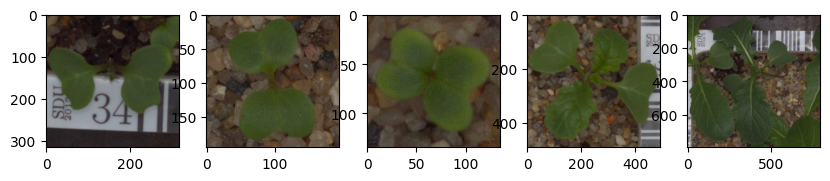

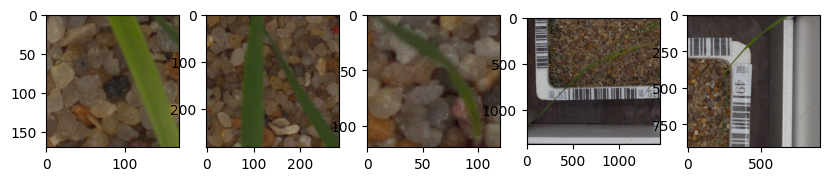

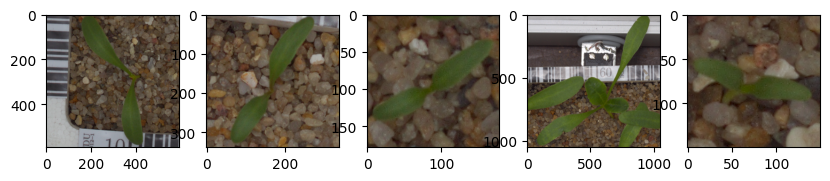

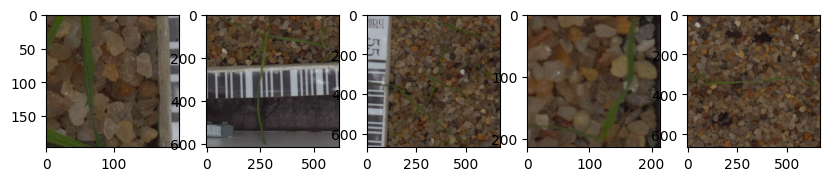

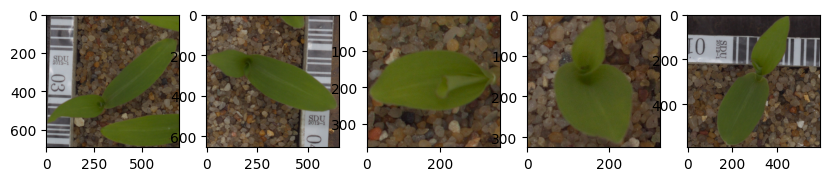

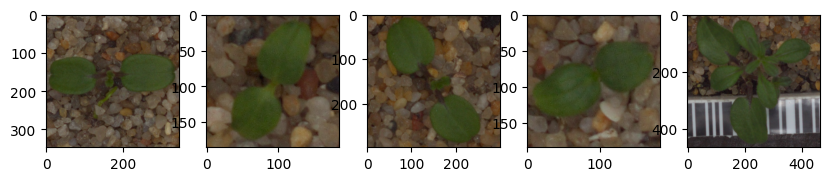

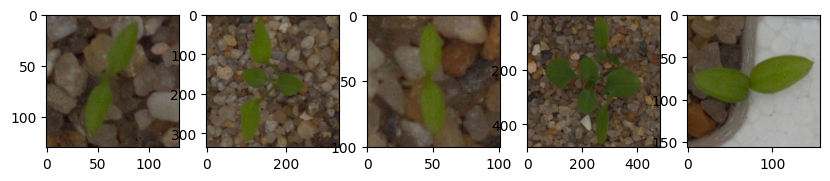

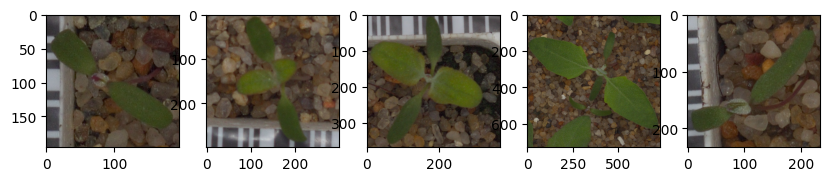

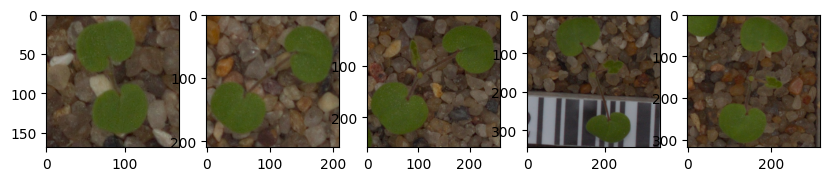

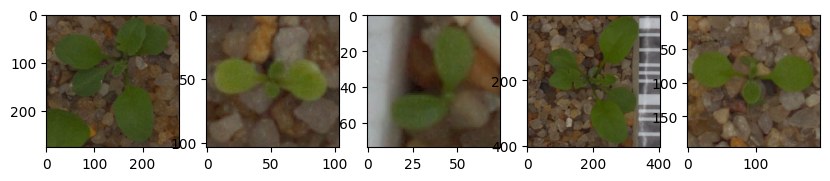

In [7]:
## plotting 5 images from each class
for image_dir in os.listdir(data_dir):
    path=os.path.join(data_dir,image_dir)
    plot_images(path,5)

#### Splitting the Dataset

In [8]:
## Declaration of variable
train_datagen=ImageDataGenerator(rescale=1/255)
valid_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

#### Creating a directory for train-test-valid dataset

In [9]:
splitfolders.ratio(
    "/kaggle/input/psc-image",
    output="./dataset",
   seed=10,
   ratio=(0.7,0.15, 0.15)
)

Copying files: 5539 files [01:18, 70.95 files/s] 


#### Dataset Loading

In [10]:
## loading the train-test-valid data
train_data=train_datagen.flow_from_directory(directory='/kaggle/working/dataset/train',
                                            target_size=(224,224),
                                            batch_size=50)
valid_data=valid_datagen.flow_from_directory(directory='/kaggle/working/dataset/val',
                                            target_size=(224,224),
                                            batch_size=50,
                                            )
test_data=test_datagen.flow_from_directory(directory='/kaggle/working/dataset/test',
                                          target_size=(224,224),
                                          batch_size=50,
                                           shuffle=False)

Found 3872 images belonging to 12 classes.
Found 825 images belonging to 12 classes.
Found 842 images belonging to 12 classes.


> ## Model Building

> #### 1.ResNet50

In [18]:
model_resnet50=tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet',
    classes=12,
    classifier_activation='softmax')

In [15]:
# function to add the fully-connected layer into my convoltion layer of ResNet50
def prepare_full_model(model,freeze_all,freeze_till,learning_rate):
    if freeze_all:
        for layer in model.layers:
            model.trianable=False
    elif (freeze_till is not None) and (freeze_till>0):
        for layer in model.layers[:-freeze_till]:
            model.trainable=False
        
    flatten_in=tf.keras.layers.Flatten()(model.output)
    
    Dense_layer_1=tf.keras.layers.Dense(units=640,activation='relu')(flatten_in)
    Dropout_layer=tf.keras.layers.Dropout(0.5)(Dense_layer_1)
    Dense_layer_2=tf.keras.layers.Dense(units=264,activation='relu')(Dropout_layer)
    Dense_layer_3=tf.keras.layers.Dense(units=64,activation='relu')(Dense_layer_2)
    
    prediction=tf.keras.layers.Dense(units=12,activation='softmax')(Dense_layer_3)

    full_model=tf.keras.models.Model(inputs=model.input,outputs=prediction)

    full_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                           loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
        
    full_model.summary()
    return full_model

In [19]:
model_resnet50=prepare_full_model(model_resnet50,freeze_all=True,freeze_till=None,learning_rate=0.01)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [20]:
model_resnet50.fit(train_data,epochs=25,steps_per_epoch=25,validation_data=valid_data)

Epoch 1/25
25/25 [==============================] - 37s 903ms/step - loss: 2.3513 - accuracy: 0.2648 - val_loss: 2.6113 - val_accuracy: 0.1382
Epoch 2/25
25/25 [==============================] - 21s 833ms/step - loss: 1.0601 - accuracy: 0.6400 - val_loss: 3.3285 - val_accuracy: 0.1382
Epoch 3/25
25/25 [==============================] - 21s 846ms/step - loss: 0.5837 - accuracy: 0.8096 - val_loss: 2.7331 - val_accuracy: 0.1382
Epoch 4/25
25/25 [==============================] - 20s 800ms/step - loss: 0.4401 - accuracy: 0.8568 - val_loss: 4.1255 - val_accuracy: 0.1345
Epoch 5/25
25/25 [==============================] - 21s 828ms/step - loss: 0.3041 - accuracy: 0.9056 - val_loss: 3.1956 - val_accuracy: 0.0558
Epoch 6/25
25/25 [==============================] - 20s 811ms/step - loss: 0.2346 - accuracy: 0.9223 - val_loss: 4.1965 - val_accuracy: 0.0558
Epoch 7/25
25/25 [==============================] - 20s 805ms/step - loss: 0.1957 - accuracy: 0.9321 - val_loss: 4.2465 - val_accuracy: 0.0558

> #### 2.VGG16

In [22]:
model_vgg16=tf.keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',
    classes=12,
    classifier_activation='softmax')

In [23]:
model_vgg16=prepare_full_model(model_vgg16,freeze_all=True,freeze_till=None,learning_rate=0.01)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [24]:
model_vgg16.fit(train_data,epochs=25,steps_per_epoch=25,validation_data=valid_data)

Epoch 1/25
25/25 [==============================] - 51s 1s/step - loss: 2.5003 - accuracy: 0.1224 - val_loss: 2.4265 - val_accuracy: 0.1115
Epoch 2/25
25/25 [==============================] - 25s 988ms/step - loss: 2.4333 - accuracy: 0.1216 - val_loss: 2.3941 - val_accuracy: 0.1564
Epoch 3/25
25/25 [==============================] - 26s 1s/step - loss: 2.4107 - accuracy: 0.1416 - val_loss: 2.3846 - val_accuracy: 0.1879
Epoch 4/25
25/25 [==============================] - 26s 1s/step - loss: 2.3928 - accuracy: 0.1592 - val_loss: 2.3500 - val_accuracy: 0.1976
Epoch 5/25
25/25 [==============================] - 26s 1s/step - loss: 2.3704 - accuracy: 0.1744 - val_loss: 2.3543 - val_accuracy: 0.2303
Epoch 6/25
25/25 [==============================] - 25s 1s/step - loss: 2.3137 - accuracy: 0.2216 - val_loss: 2.1071 - val_accuracy: 0.3358
Epoch 7/25
25/25 [==============================] - 26s 1s/step - loss: 2.2813 - accuracy: 0.2480 - val_loss: 2.0093 - val_accuracy: 0.3479
Epoch 8/25
25/25 

In [ ]:
`